# **Importing Necessary Libraries**

### **Data Processing:**
- *StringIO* – for working with text data in a file stream format.
- *NumPy* – for efficient work with multidimensional arrays and computational operations.
- *pandas* – for loading, processing, and analyzing tabular data.

### **Visualization:**
- *Matplotlib* – for building graphs and charts.
- *Seaborn* – for statistical data visualization.

### **Machine Learning Methods:**
- *scikit-learn*:
    - *RandomForestClassifier* – for building a classification model based on a random forest.
    - *train_test_split* – for splitting a sample into training and testing sets.
    - *LabelEncoder* – for encoding categorical variables.
    - Metrics *accuracy_score*, *precision_score*, *recall_score*, *f1_score*, *roc_auc_score* – for evaluating model accuracy.

### **Web Data Parsing:**
- *requests* – for getting HTML pages from websites.
- *BeautifulSoup* – for processing HTML code and extracting necessary information.

### **Disabling System Warnings:**
- To avoid displaying unnecessary warning messages during code execution, the *warnings* module is used.

In [23]:
from io import StringIO  

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import requests
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Getting Data from a Website

A connection to the web resource is made and the received information is processed using *BeautifulSoup*.

In [24]:
url = "https://data-analys.netlify.app/"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

data_dict = {
    block.find("h5", class_="card-title").get_text(strip=True): 
    block.find("p", class_="card-text").get_text(strip=True)
    for block in soup.find_all("div", class_="card mb-3")[-2:]
}

print(data_dict.keys())

dict_keys(['Activity', 'Active users'])


**Data Preparation and Processing**

Loading, combining, and cleaning datasets for further analysis.

In [25]:
df_Active_users = pd.read_csv(StringIO(data_dict['Active users']))
df_Activity = pd.read_csv(StringIO(data_dict['Activity']))

df = df_Activity.merge(df_Active_users, how='left', on='user_id')

df['language'] = df['language'].replace('ru', 'plt')
df['activity_date'] = pd.to_datetime(df['activity_date'])
df = df.drop(df[df['total_seconds'] > df['total_seconds'].quantile(0.95)].index, axis=0).reset_index(drop=True)

print(df.info())
print(df.isna().sum())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41811 entries, 0 to 41810
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_id                 41811 non-null  object        
 1   activity_date           41811 non-null  datetime64[ns]
 2   game_activity_name      41811 non-null  object        
 3   total_seconds           41811 non-null  int64         
 4   game_name               41811 non-null  object        
 5   language                41811 non-null  object        
 6   has_older_device_model  41811 non-null  bool          
 7   age                     41811 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(4)
memory usage: 2.3+ MB
None
user_id                   0
activity_date             0
game_activity_name        0
total_seconds             0
game_name                 0
language                  0
has_older_device_model    0
age          

,user_id,activity_date,game_activity_name,total_seconds,game_name,language,has_older_device_model,age
0,5Xx7q8xw22flTcYbZ1XZVQ==,2022-09-25,game 3: Main campaign,266,game 3,uk,False,26
1,5Xx7q8xw22flTcYbZ1XZVQ==,2022-09-25,game 3: Special events,43,game 3,uk,False,26
2,C/7YatYfa4qFbB1omZ7Jjw==,2022-09-05,game 2: Battle pass challenges,51,game 2,uk,False,52
3,C/7YatYfa4qFbB1omZ7Jjw==,2022-09-28,game 2: Battle pass challenges,846,game 2,uk,False,52
4,C/7YatYfa4qFbB1omZ7Jjw==,2022-10-13,game 2: Battle pass challenges,656,game 2,uk,False,52


# Analysis of User Language Distribution

Visualization of the number of users by language categories.

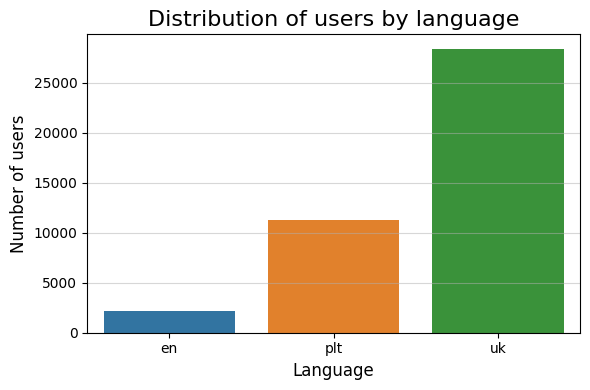

In [26]:
language = df.groupby('language')['user_id'].count()

plt.figure(figsize=(6, 4))
sns.barplot(x=language.index, y=language, hue=language.index)
plt.xlabel("Language", fontsize=12)
plt.ylabel("Number of users", fontsize=12)
plt.title("Distribution of users by language", fontsize=16)
plt.grid(axis="y", linestyle="-", alpha=0.5)

plt.tight_layout()

plt.show()

# Analysis of Obsolete Device Usage

The chart shows the distribution of users depending on the presence of an outdated device model.

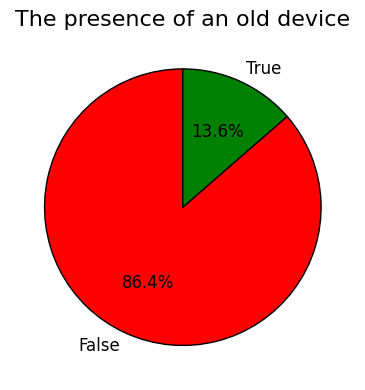

In [27]:
has_older_device = df.groupby('has_older_device_model')['user_id'].count().reset_index()

plt.figure(figsize=(6, 4))

plt.pie(
    has_older_device['user_id'], 
    labels=has_older_device['has_older_device_model'], 
    colors=["red", "green"], 
    startangle=90, 
    textprops={"fontsize": 12}, 
    wedgeprops={"linewidth": 1, "edgecolor": "black"}, 
    autopct="%1.1f%%"
)

plt.title('The presence of an old device', fontsize=16)

plt.tight_layout()

plt.show()


# User Activity Dynamics

### Key Metrics:
- **DAU (Daily Active Users)** – the number of unique users who logged into the system during the day.
- **WAU (Weekly Active Users)** – the number of unique users per week, which helps to assess the stability of engagement.
- **MAU (Monthly Active Users)** – the number of unique users per month, which allows for the analysis of long-term activity.

The charts show the number of active users per day (DAU), week (WAU), and month (MAU).
This analysis helps to assess the overall level of activity and identify possible trends.

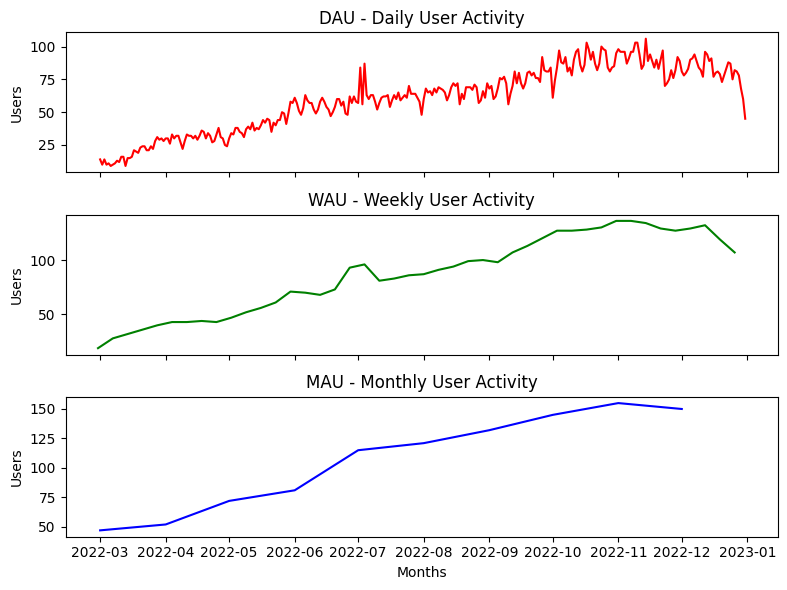

In [28]:
dau = df.groupby('activity_date')['user_id'].nunique().reset_index()

df['week_start_date'] = df['activity_date'].dt.to_period('W').apply(lambda x: x.start_time)
wau = df.groupby('week_start_date')['user_id'].nunique().reset_index()

df['month_start_date'] = df['activity_date'].dt.to_period('M').apply(lambda x: x.start_time)
mau = df.groupby('month_start_date')['user_id'].nunique().reset_index()

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

sns.lineplot(ax=axes[0], x=dau["activity_date"], y=dau['user_id'], color="red")
axes[0].set_title("DAU - Daily User Activity")
axes[0].set_ylabel("Users")

sns.lineplot(ax=axes[1], x=wau["week_start_date"], y=wau['user_id'], color="green")
axes[1].set_title("WAU - Weekly User Activity")
axes[1].set_ylabel("Users")

sns.lineplot(ax=axes[2], x=mau["month_start_date"], y=mau["user_id"], color="blue")
axes[2].set_title("MAU - Monthly User Activity")
axes[2].set_ylabel("Users")
axes[2].set_xlabel("Months")

plt.tight_layout()
plt.show()

# 📉 Average DAU to WAU Ratio

### What is being analyzed?

- **Average DAU for the week** – The average number of daily active users for the week:
$$ \text{Average DAU} = \frac{\sum_{i=1}^{7} DAU_i}{7} $$
- **Average DAU/WAU** – an indicator that helps to assess how often users interact with the system during the week.

### Interpretation:
- A **DAU/WAU** value close to 1 means that users are active almost every day.
- A low value indicates that most users log in only a few times a week.

This analysis helps to assess the level of user engagement and predict trends in their behavior.

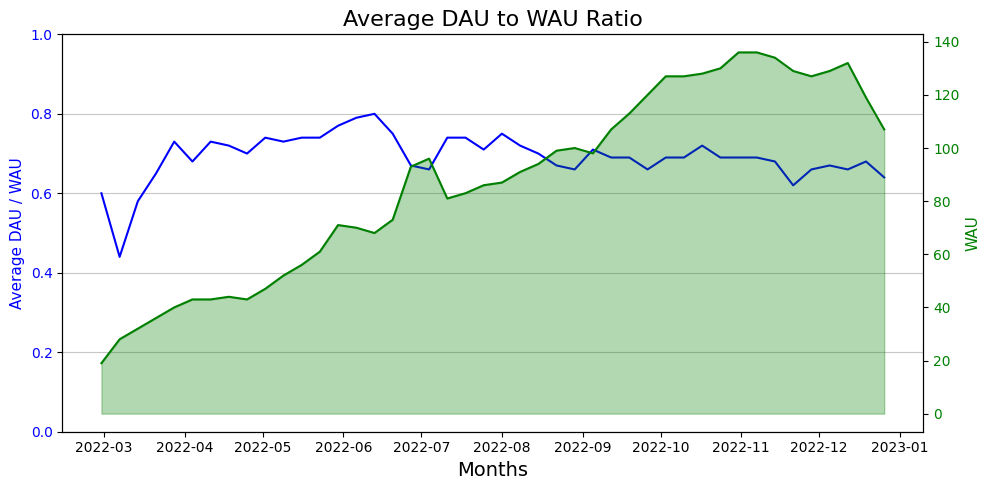

In [29]:
dau['week_start_date'] = dau['activity_date'].dt.to_period('W').apply(lambda x: x.start_time)
average_dau = dau.groupby('week_start_date')['user_id'].mean().reset_index().round(2)

dau_to_wau = (average_dau['user_id'] / wau['user_id']).round(2)

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Months', fontsize=14)
ax1.set_ylabel('Average DAU / WAU', color='blue', fontsize=11)
ax1.plot(average_dau['week_start_date'], dau_to_wau, color='blue', label='DAU / WAU')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1)
ax1.yaxis.grid(True, linestyle='-', alpha=0.7)

ax2 = ax1.twinx()
ax2.set_ylabel('WAU', color='green', fontsize=11)
ax2.fill_between(wau['week_start_date'], wau['user_id'], color='green', alpha=0.3)
ax2.plot(wau['week_start_date'], wau['user_id'], color='green', label='WAU')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_title("Average DAU to WAU Ratio", fontsize=16)

fig.tight_layout()
plt.show()

# 🔥 User Cohort Analysis

Cohort analysis helps to assess **user retention** over certain periods, grouping them by the month of their first activity.

### Key Metrics:
- **Number of users in each cohort** (a heatmap in green shades).
- **User retention percentage** in the months following the first activity (a heatmap in blue shades).

### Interpretation:
- A high retention value means that users remain active for a long time.
- Low retention indicates possible problems with audience engagement or interest.

This analysis is useful for evaluating the product's long-term effectiveness and optimizing the user experience.

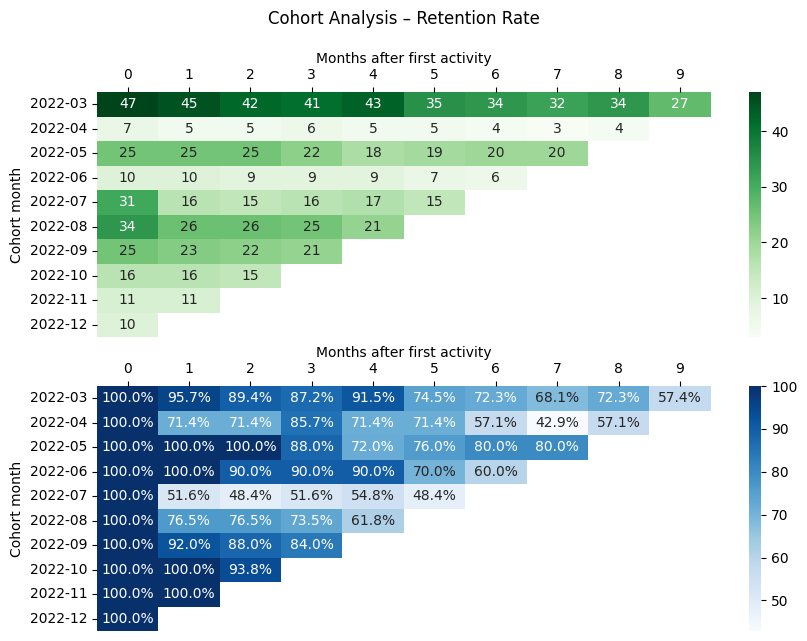

In [30]:
df['cohort_month'] = df.groupby('user_id')['activity_date'].transform('min').dt.to_period('M')
df["activity_month"] = df["activity_date"].dt.to_period("M")
df["cohort_index"] = (df["activity_month"] - df["cohort_month"]).apply(lambda x: x.n)

cohort_table = df.groupby(["cohort_month", "cohort_index"])["user_id"].nunique().unstack().fillna(0)

cohort_size = cohort_table.iloc[:, 0]
retention_matrix = cohort_table.div(cohort_size, axis=0) * 100

annot = retention_matrix.applymap(lambda x: f"{x:.1f}%" if x > 0 else "")

fig, axes = plt.subplots(2, 1, figsize=(7*np.sqrt(2), 7), gridspec_kw={'wspace': 0.3})

ax1 = sns.heatmap(cohort_table, annot=True, cmap="Greens", mask=cohort_table == 0, ax=axes[0])
ax1.set_title("Cohort Analysis – Retention Rate", pad=20)
ax1.set_xlabel("Months after first activity")
ax1.set_ylabel("Cohort month")
ax1.xaxis.set_label_position("top")
ax1.xaxis.tick_top()

ax2 = sns.heatmap(retention_matrix, annot=annot, fmt="", cmap="Blues", mask=retention_matrix == 0, ax=axes[1])
ax2.set_xlabel("Months after first activity")
ax2.set_ylabel("Cohort month")
ax2.xaxis.set_label_position("top")
ax2.xaxis.tick_top()

plt.show()

## 📉 Analysis of User Churn Rate by Game

This analysis helps to assess the **percentage of users who have stopped being active** (churn) for each game. This is a key metric for understanding the long-term effectiveness and attractiveness of the product.

* **Calculation of user activity**: The date of the user's first and last activity is determined, as well as the total number of active days.
* **Days since last activity**: The number of days that have passed since the user's last activity until the current maximum date in the data is calculated.
* **User lifetime**: The total number of days the user has been active is determined.
* **Determining churn**: A user is considered "churned" if their last activity was more than 7 days ago, and they were active for at least 7 days (to distinguish them from those who just "looked in").
* **Calculation of Churn Rate by game**: The percentage of churn is calculated for each individual game.

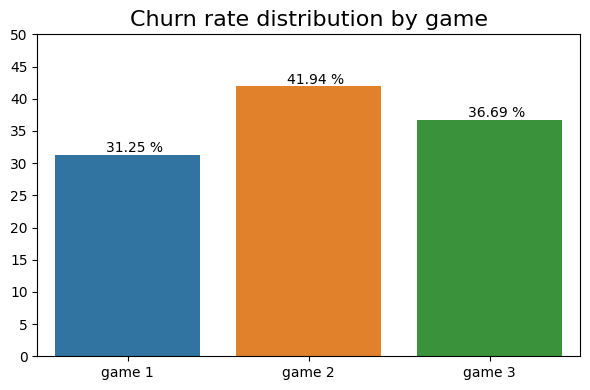

In [31]:
# Calculating user statistics
max_date = df['activity_date'].max()

user_visits = df.groupby('user_id').agg({
    'activity_date': ['min', 'max', 'nunique']
}).reset_index()

user_visits.columns = ['user_id', 'first_activity', 'last_activity', 'total_active_days']

# Calculating key metrics
user_visits['days_since_last_activity'] = (max_date - user_visits['last_activity']).dt.days
user_visits['user_lifetime_days'] = (user_visits['last_activity'] - user_visits['first_activity']).dt.days + 1

user_visits['churn'] = (
    (user_visits['days_since_last_activity'] > 7) &
    (user_visits['user_lifetime_days'] >= 7)
).astype(int)

# For reuse, remove the 'churn' column from the main DataFrame if it exists
if 'churn' in df.columns:
    df = df.drop('churn', axis=1)

# Adding churn to the main DataFrame
df = df.merge(user_visits[['user_id', 'churn']], on='user_id', how='left')

# Identifying unique users
unique_users_df = df.copy()
unique_users_df.drop_duplicates(subset='user_id', inplace=True)
unique_users_df.reset_index(inplace=True)

# Calculating churn rate for each game
churn_rate = (unique_users_df.groupby('game_name')['churn'].sum()
                /
                unique_users_df.groupby('game_name')['user_id'].nunique() * 100).round(2)

# Visualization of the number of users who have left the game
plt.figure(figsize=(6,4))

sns.barplot(x=churn_rate.index, y=churn_rate.values, hue=churn_rate.index)

for i, v in enumerate(churn_rate.values):
    plt.text(i-0.12, v + 0.4, f'{v} %')

plt.title('Churn rate distribution by game', fontsize=16)

plt.xlabel('')
plt.yticks(np.arange(0,51, 5))

# Automatic layout adjustment
plt.tight_layout()

plt.show()

## Determining Key User Churn Factors

This model **determines which factors have the greatest influence on customer churn**.


1. **Features** are formed that can influence churn:
    - Age
    - Language
    - The presence of an old device
    - Activity diversity
    - Number of active days in the game
    - Whether the player is active during the first week

2. **The model is trained** (*Random Forest Classifier*), which predicts the probability of churn.

3. The importance of the factors is determined to understand **which variables have the greatest influence on churn**.

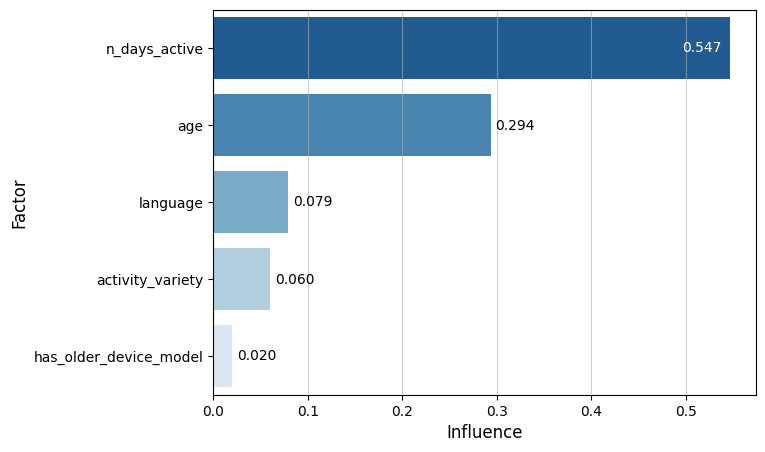

In [32]:
# Counting the number of active days for each user
df['n_days_active'] = df.groupby('user_id')['activity_date'].transform('nunique')

# Counting activity variety
df['activity_variety'] = df.groupby('user_id')['game_activity_name'].transform('nunique')

# Encoding categorical variables 
df['language'] = LabelEncoder().fit_transform(df['language'])
df['has_older_device_model'] = df['has_older_device_model'].astype(int)

# Forming the feature set and target variable
features = ['age', 'language', 'has_older_device_model', 'activity_variety', 'n_days_active']
X = df[features]
y = df['churn']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Creating and training the Random Forest model
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

# Model evaluation
y_pred_proba = rf.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.6).astype(int)

# Feature importance
feature_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

# Building a feature importance chart
plt.figure(figsize=(7, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="Blues_r")

for index, value in enumerate(feature_importance.values):
    if value > 0.5:
        plt.text(value - 0.05, index, f"{value:.3f}", va='center', color='white')
    else:
        plt.text(value + 0.005, index, f"{value:.3f}", va='center')

plt.xlabel('Influence', fontsize=12)
plt.ylabel('Factor', fontsize=12)
plt.grid(axis="x", linestyle="-", alpha=0.6)
plt.show()

#### **🔎 Conclusion**

Besides the obvious influence of activity, **the player's age plays a significant role**. This means that certain age groups are prone to more or less churn, and it is worth adapting the game content or communication accordingly.

At the same time, **language, player variety, and device model have practically no influence** on user churn. This suggests that technical limitations or language factors are not key barriers to audience retention.

In [33]:
print("Overall distribution of user age:\n", unique_users_df['age'].describe().round(1), '\n')
print("Distribution of user age for game 1:\n", unique_users_df[unique_users_df['game_name'] == 'game 1']['age'].describe().round(1), '\n')
print("Distribution of user age for game 2:\n", unique_users_df[unique_users_df['game_name'] == 'game 2']['age'].describe().round(1), '\n')
print("Distribution of user age for game 3:\n", unique_users_df[unique_users_df['game_name'] == 'game 3']['age'].describe().round(1), '\n')

Overall distribution of user age:
 count    216.0
mean      28.0
std       11.3
min       14.0
25%       19.0
50%       25.0
75%       34.0
max       83.0
Name: age, dtype: float64 

Distribution of user age for game 1:
 count    16.0
mean     35.6
std       8.5
min      24.0
25%      30.2
50%      34.5
75%      40.2
max      51.0
Name: age, dtype: float64 

Distribution of user age for game 2:
 count    31.0
mean     40.9
std      15.7
min      18.0
25%      28.5
50%      40.0
75%      51.0
max      83.0
Name: age, dtype: float64 

Distribution of user age for game 3:
 count    169.0
mean      24.9
std        8.2
min       14.0
25%       18.0
50%       23.0
75%       30.0
max       44.0
Name: age, dtype: float64 

